In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from DSOhelper import addsubfiglabels,get_oscilloscope_data,getvoltage,plot_scope_data,subplot_scope_data
from statsmodels.tsa import stattools #conda install -c conda-forge statsmodels
from scipy import signal
from scipy.signal import find_peaks
from time import time as t

## determine the mean height of peaks vs overvoltage

In [3]:
datafolder = "vary_led_1562/"
files = sorted([f for f in os.listdir(datafolder) if f[:4]=="temp"])
file=files[0]
len(files),files[::len(files)-1]

(10000, ['temp0000000.CSV', 'temp0009999.CSV'])

In [4]:
dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")

In [5]:
headers

{1: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH1',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 10.0,
  'Vertical Scale': 0.5,
  'Vertical Position': -1.78,
  'Horizontal Units': 'S',
  'Horizontal Scale': 2e-05,
  'Horizontal Position': -3.2e-06,
  'Horizontal Mode': 'Main',
  'SincET Mode': 'Real Time',
  'Sampling Period': 2e-08,
  'Horizontal Old Scale': 2e-05,
  'Horizontal Old Position': -3.2e-06,
  'Firmware': 'V1.23',
  'Mode': 'Fast'},
 2: {'Memory Length': 10000.0,
  'IntpDistance': 0.0,
  'Trigger Address': 5159.0,
  'Trigger Level': 0.3,
  'Source': 'CH2',
  'Vertical Units': 'V',
  'Vertical Units Div': 0.0,
  'Vertical Units Extend Div': 16.0,
  'Label': '',
  'Probe Type': 0.0,
  'Probe Ratio': 1.0,
  'Vertical Scale': 0.2,
  'Vertical Position': -2.24,
  'Horizontal Units': 'S',
  'Horizontal Scale'

In [6]:
headers[1]["Sampling Period"],headers[1]["Vertical Scale"]

(2e-08, 0.5)

### plotting a subset of data for sanity check

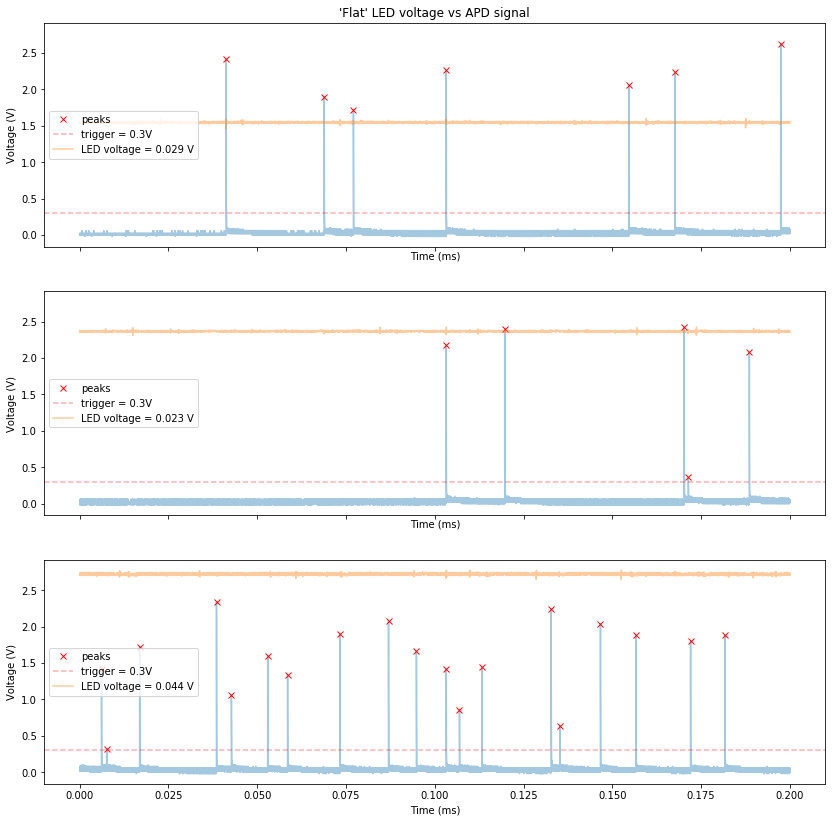

In [7]:
zeroOverVoltage = 139.3
CH=1
fig,axx = plt.subplots(3,1,figsize=(14,14),sharey=True,sharex=True)
for i,file,ax in zip(range(len(axx)),['temp0000205.CSV','temp0005505.CSV','temp0009505.CSV'],axx):
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    xscale=1e3
    subplot_scope_data(dataseq,headers,ax,alpha=0.4,xscale=xscale) 
    peak_x , peak_heights = find_peaks(dataseq[CH],height=15)
    ax.plot(peak_x*headers[CH]["Sampling Period"]*xscale,getvoltage(peak_heights["peak_heights"],headers[CH]),"x",c="r",alpha=0.96,label="peaks")
    ax.axhline(headers[CH]["Trigger Level"],c="r",ls="--",alpha=0.3,label=f"trigger = {headers[CH]['Trigger Level']}V")
    subplot_scope_data(dataseq,headers,ax,CH=2,alpha=0.4,xscale=xscale,label=f"LED voltage = {np.mean(getvoltage(dataseq[CH] ,headers[CH])):.3f} V")
    ax.legend(loc="center left")
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Time (ms)")
    if i ==0:
        ax.set_title("'Flat' LED voltage vs APD signal")
plt.savefig("results08_01_flatLEDvoltage.png")

In [8]:
%%time
average_led_voltage=[]
average_peak_counts = []
for file in files[::]:
    dataseq,headers=get_oscilloscope_data(f"{datafolder}{file}")
    average_led_voltage.append(np.mean(getvoltage(dataseq[2],headers[2])))
    peak_x , peak_heights = find_peaks(dataseq[1],height=15)
    average_peak_counts.append(len(peak_x))

CPU times: user 1min 48s, sys: 1.58 s, total: 1min 49s
Wall time: 1min 50s


NameError: name 'AnchoredText' is not defined

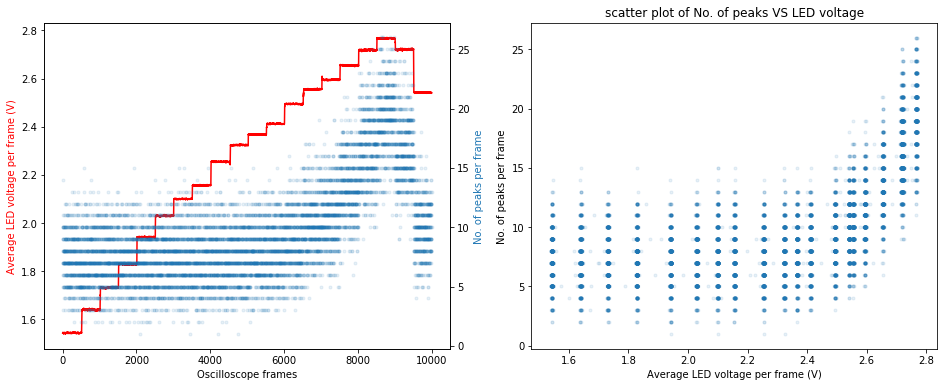

In [359]:
fig,axx = plt.subplots(1,2,figsize=(16,6))
ax=axx[0]
ax.plot(average_led_voltage,color="red")
##ax.set_title("LED voltage")
ax.set_ylabel("Average LED voltage per frame (V)",color="red")
ax.set_xlabel("Oscilloscope frames")
ax=axx[0].twinx()
ax.plot(average_peak_counts,".",alpha=0.1)
#ax.set_title("counts per frame")
ax.set_ylabel("No. of peaks per frame",color="tab:blue")

ax=axx[1]
ax.scatter(average_led_voltage,average_peak_counts,marker=".",alpha=0.1)
ax.set_xlabel("Average LED voltage per frame (V)")
ax.set_ylabel("No. of peaks per frame")
ax.set_title("scatter plot of No. of peaks VS LED voltage")
addsubfiglabels(axx)
plt.savefig("results08_02_overviewplot_with_transients.png")

## G2 plot, are photons from led coherent?

In [310]:
voltages = getvoltage(dataseq[1],headers[1])

$$g^{(2)}(\tau) = \frac{\langle I(t) I(t+\tau) \rangle}{\langle I(t) \rangle ^2}$$

In [338]:
def g(tau,inten,averaged_over=9000):
    denominator = np.mean([inten[:averaged_over],inten[tau:tau+averaged_over]])**2
    return np.mean( [inten[i] * inten[i+tau] for i in range(averaged_over) ])/denominator

In [339]:
%%time
t0 = t()
g2_custom = [g(tau,voltages) for tau in range(1000)]
t1 = t()-t0

CPU times: user 3.45 s, sys: 3.86 ms, total: 3.45 s
Wall time: 3.45 s


In [340]:
%%time
t0 = t()
g2_stattool = stattools.acf(voltages,nlags=1000)
t2 = t()-t0

CPU times: user 82.6 ms, sys: 0 ns, total: 82.6 ms
Wall time: 22.5 ms


CPU times: user 50.3 ms, sys: 3 µs, total: 50.3 ms
Wall time: 49.2 ms


Text(0.5, 0, 'Time lag, $\\tau$ (ms)')

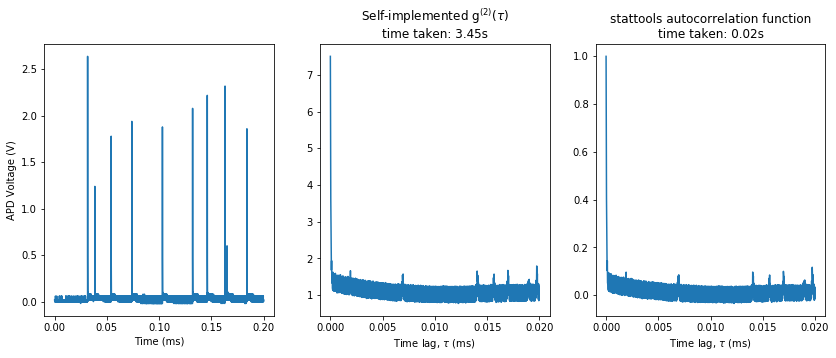

In [358]:
%%time
#voltages = np.sin(5*np.linspace(0,2*np.pi,10000))+10
fig,axx=plt.subplots(1,3,figsize=(14,5))
ax = axx[0]
ax.plot(np.arange(len(voltages))*headers[1]["Sampling Period"]*xscale,voltages)
ax.set_xlabel(r"Time (ms)")
ax.set_ylabel("APD Voltage (V)")
ax = axx[1]
ax.plot(np.arange(len(g2_custom))*headers[1]["Sampling Period"]*xscale,g2_custom)
ax.set_title(r"Self-implemented g$^{(2)}(\tau)$"+f"\ntime taken: {t1:.2f}s")
ax.set_xlabel(r"Time lag, $\tau$ (ms)")
ax = axx[2]
ax.plot(np.arange(len(g2_custom)+1)*headers[1]["Sampling Period"]*xscale,g2_stattool)
ax.set_title(r"stattools autocorrelation function"+f"\ntime taken: {t2:.2f}s")
ax.set_xlabel(r"Time lag, $\tau$ (ms)")

In [279]:
x= np.linspace(0,2*np.pi,1000)
voltsx=np.sin(5*x)*np.exp(-1*x)+10+np.random.standard_normal(len(x))
voltsy = voltsx #np.concatenate([np.random.standard_normal(100), voltsx[:-100]])

In [280]:
def get_autocorrelation(voltsx):
    meanvolt = np.mean(voltsx)
    return np.real(np.fft.ifft(np.conjugate(np.fft.fft(voltsx[::-1]))*np.fft.fft(voltsx)))/meanvolt**2/len(voltsx)

In [281]:
%%time
corr = get_autocorrelation(voltsx)

CPU times: user 983 µs, sys: 0 ns, total: 983 µs
Wall time: 694 µs


In [291]:
%%time
meanvolt = np.mean(voltsx[:100])
corr2 = np.array([g(tau,voltsx) for tau in range(100)])/meanvolt**2
#corr2 = stattools.acf( voltsx )

CPU times: user 72.2 ms, sys: 43 µs, total: 72.2 ms
Wall time: 69.4 ms


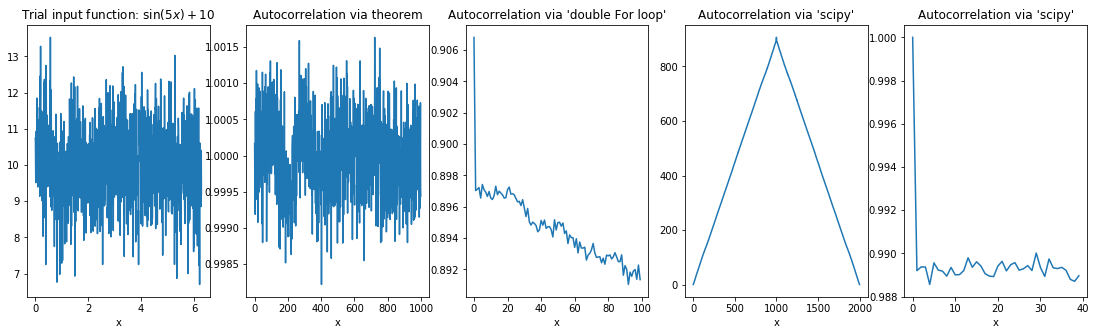

In [292]:
fig,axx=plt.subplots(1,5,figsize=(19,5))
ax=axx[0]
ax.plot(x,voltsx)
ax.set_title(r"Trial input function: sin$(5 x)+10$")
ax=axx[1]
ax.plot(corr)
ax.set_title("Autocorrelation via theorem")
ax=axx[2]
ax.plot(corr2)
ax.set_title("Autocorrelation via 'double For loop'")
ax=axx[3]
ax.plot(np.correlate(voltsx,voltsx,mode="full")/meanvolt**2)
ax.set_title("Autocorrelation via 'scipy'")
ax=axx[4]
ax.plot(cross_correlation(voltsx,voltsx)[999:999+40])
ax.set_title("Autocorrelation via 'scipy'")

for ax in axx:
    ax.set_xlabel("x")

In [75]:
from scipy import signal 
x = voltsx#np.random.standard_normal(1000)
y = voltsy#np.concatenate([np.random.standard_normal(100), x])
correlation = signal.correlate(x, y, mode="same")

In [76]:
%%time
correlation = signal.correlate(x, y, mode="full")

CPU times: user 6.18 ms, sys: 4.04 ms, total: 10.2 ms
Wall time: 3.48 ms


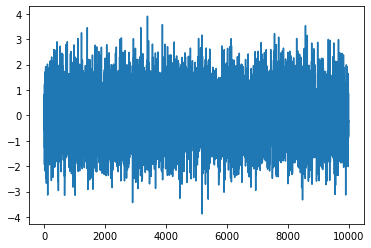

In [77]:
plt.plot(x)

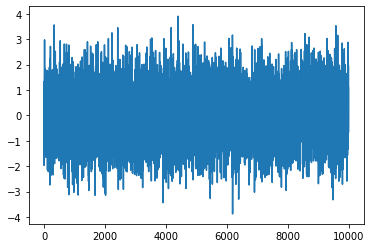

In [78]:
plt.plot(y)

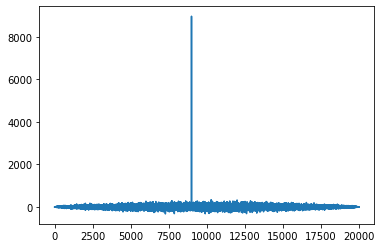

In [79]:
plt.plot(correlation[:])